In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

from statsmodels.tsa.arima_model import ARIMA

from prophet import Prophet
import xgboost as xgb



In [4]:
#!conda install prophet -y

In [5]:
full_data=pd.read_csv(r"..\data\GlobalLandTemperaturesByCountry.csv")

In [6]:
display(full_data.shape, full_data.head)

(577462, 4)

<bound method NDFrame.head of                 dt  AverageTemperature  AverageTemperatureUncertainty  \
0       1743-11-01               4.384                          2.294   
1       1743-12-01                 NaN                            NaN   
2       1744-01-01                 NaN                            NaN   
3       1744-02-01                 NaN                            NaN   
4       1744-03-01                 NaN                            NaN   
...            ...                 ...                            ...   
577457  2013-05-01              19.059                          1.022   
577458  2013-06-01              17.613                          0.473   
577459  2013-07-01              17.000                          0.453   
577460  2013-08-01              19.759                          0.717   
577461  2013-09-01                 NaN                            NaN   

         Country  
0          Åland  
1          Åland  
2          Åland  
3          Åland 

In [7]:
# Convert the "date" column to a datetime format
full_data.loc[:, 'date'] = pd.to_datetime(full_data['dt'])

# Extract the year from the "date" column and create a new "year" column
full_data.loc[:, 'year'] = full_data['date'].dt.year

In [8]:
full_data.dropna(subset=['AverageTemperature'], inplace=True)
full_data.drop(columns=["dt","AverageTemperatureUncertainty"], inplace=True)

In [9]:
full_data.columns = ["AverageTemperature","country","date","year"]

In [10]:
    # Group the data by "country" and "year" and calculate the annual maximum temperature
max_temp = full_data.groupby(['country', 'year'])['AverageTemperature'].max().reset_index()
max_temp.rename(columns={'AverageTemperature': 'HighestTemperature'}, inplace=True)

In [11]:
    # Group the data by "country" and "year" and calculate the annual minimum temperature
min_temp = full_data.groupby(['country', 'year'])['AverageTemperature'].min().reset_index()
min_temp.rename(columns={'AverageTemperature': 'LowestTemperature'}, inplace=True)


In [12]:
# Group the data by "country" and "year" and calculate the annual average temperature
avg_temp = full_data.groupby(['country', 'year'])['AverageTemperature'].mean().reset_index()
avg_temp.rename(columns={'AverageTemperature': 'AnnualAverageTemperature'}, inplace=True)


In [13]:
    # Merge the three DataFrames on "country" and "year"
result = pd.merge(max_temp, min_temp, on=['country', 'year'])
result = pd.merge(result, avg_temp, on=['country', 'year'])

In [14]:
full_data.head

<bound method NDFrame.head of         AverageTemperature   country       date  year
0                    4.384     Åland 1743-11-01  1743
5                    1.530     Åland 1744-04-01  1744
6                    6.702     Åland 1744-05-01  1744
7                   11.609     Åland 1744-06-01  1744
8                   15.342     Åland 1744-07-01  1744
...                    ...       ...        ...   ...
577456              21.142  Zimbabwe 2013-04-01  2013
577457              19.059  Zimbabwe 2013-05-01  2013
577458              17.613  Zimbabwe 2013-06-01  2013
577459              17.000  Zimbabwe 2013-07-01  2013
577460              19.759  Zimbabwe 2013-08-01  2013

[544811 rows x 4 columns]>

In [15]:
result.head

<bound method NDFrame.head of            country  year  HighestTemperature  LowestTemperature  \
0      Afghanistan  1838              26.877              7.475   
1      Afghanistan  1840              27.739              0.735   
2      Afghanistan  1841              27.104             -0.883   
3      Afghanistan  1842              25.798              3.330   
4      Afghanistan  1843              26.748              0.674   
...            ...   ...                 ...                ...   
45910        Åland  2009              16.423             -2.544   
45911        Åland  2010              19.119             -6.416   
45912        Åland  2011              18.003             -6.390   
45913        Åland  2012              16.050             -3.454   
45914        Åland  2013              16.447             -4.779   

       AnnualAverageTemperature  
0                     18.379571  
1                     13.413455  
2                     13.997600  
3                     15.1546

In [52]:
# List of countries to include in the plot
column_names = ["country","year",'highest_temperature', 'lowest_temperature', 'annual_average_temperature']
temperature_categories = {
    'highest_temperature': 'red',
    'lowest_temperature': 'blue',
    'annual_average_temperature': 'green'
}
categories_to_plot = ['highest_temperature', 'lowest_temperature', 'annual_average_temperature']
country_list = ['Ukraine', 'Germany', 'France', "United Kingdom"]


In [53]:
result.columns=column_names
display(result.head)

<bound method NDFrame.head of            country  year  highest_temperature  lowest_temperature  \
0      Afghanistan  1838               26.877               7.475   
1      Afghanistan  1840               27.739               0.735   
2      Afghanistan  1841               27.104              -0.883   
3      Afghanistan  1842               25.798               3.330   
4      Afghanistan  1843               26.748               0.674   
...            ...   ...                  ...                 ...   
45910        Åland  2009               16.423              -2.544   
45911        Åland  2010               19.119              -6.416   
45912        Åland  2011               18.003              -6.390   
45913        Åland  2012               16.050              -3.454   
45914        Åland  2013               16.447              -4.779   

       annual_average_temperature  
0                       18.379571  
1                       13.413455  
2                       13.997600

In [54]:
def remove_outliers(df, country_list, temperature_categories):
    united_data = pd.DataFrame()
    for country in country_list:
        for category in temperature_categories:
            q1 = df[(df['country'] == country)][category].quantile(0.25)
            q3 = df[(df['country'] == country)][category].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            country_data = df[(df['country'] == country) & (df[category] >= lower_bound) & (df[category] <= upper_bound)]
            united_data = pd.concat([united_data, country_data])
    return united_data


In [55]:
united_data = remove_outliers(result, country_list, categories_to_plot)


In [56]:
def box_plots(df, temperature_categories, country_list):
    sns.set(style="whitegrid")

    # Create subplots to arrange box plots vertically
    fig, axes = plt.subplots(nrows=len(temperature_categories), ncols=1, figsize=(10, 4 * len(temperature_categories)))

    for i, category in enumerate(temperature_categories):
        ax = axes[i]
        ax.set_title(f'{category} by Country')
        sns.boxplot(x='country', y=category, data=df, palette='Set2', ax=ax)
        ax.set_ylabel(category)  # Set y-axis label for the current category

    plt.tight_layout()

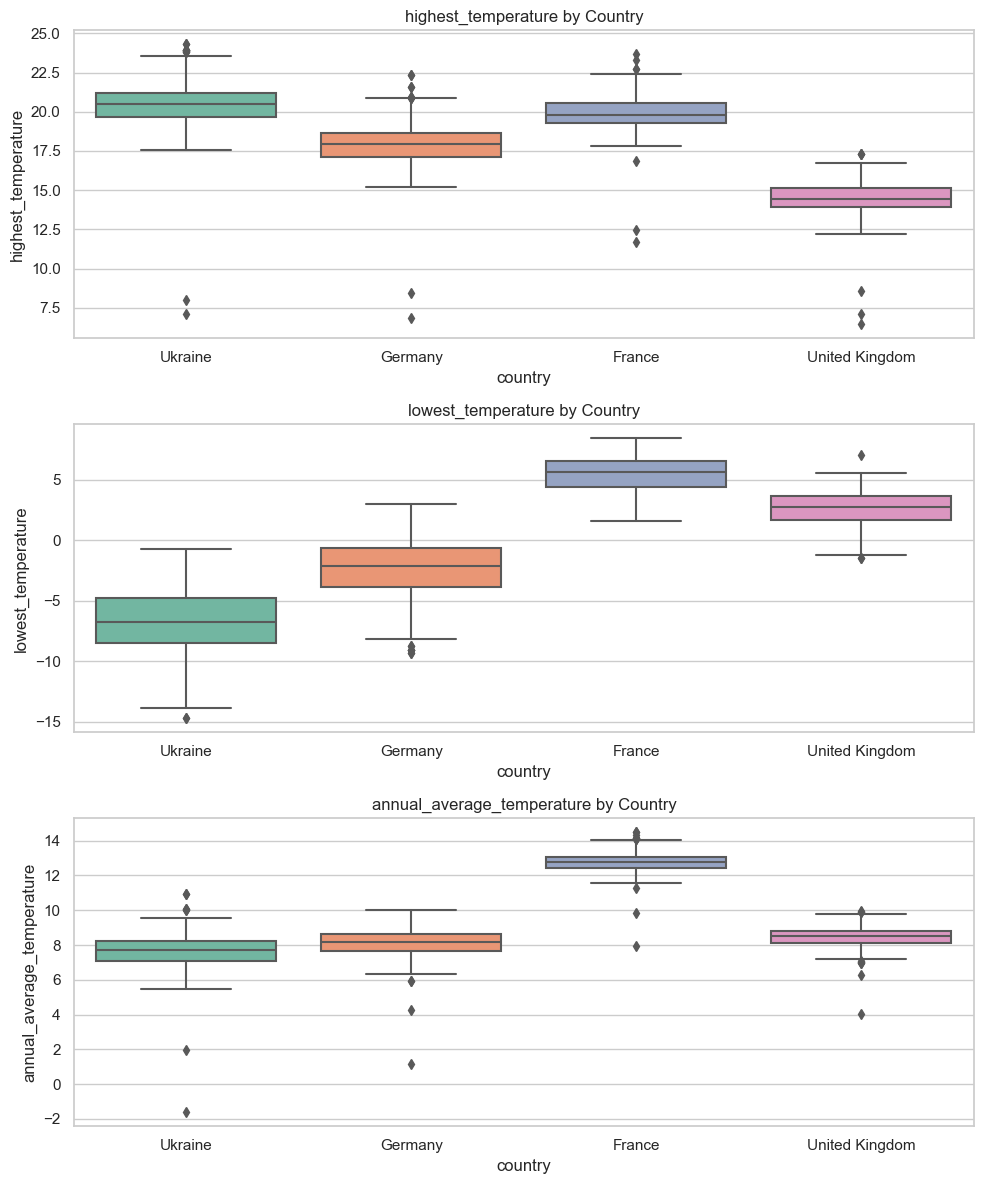

In [58]:
box_plots(united_data, temperature_categories, country_list)

In [59]:
def country_plotter(df, temperature_categories, country_list):
    # Create scatter plots and trendlines for each category on the same plot, one plot per country
    sns.set(style="whitegrid")
    categories_to_plot = list(temperature_categories.keys())
    
    num_countries = len(country_list)
    
    for country in country_list:
        plt.figure(figsize=(10, 4))  # Reduce the figure size to fit in two columns
        plt.title(f'Temperature Trends for {country}')
        
        for category, color in temperature_categories.items():
            country_data = df[df['country'] == country]
            sns.scatterplot(x='year', y=category, data=country_data, label=f'{category}', color=color)
            sns.regplot(x='year', y=category, data=country_data, color=color, scatter=False)
        
        plt.legend(loc='best')
        plt.tight_layout()
    
    plt.show()

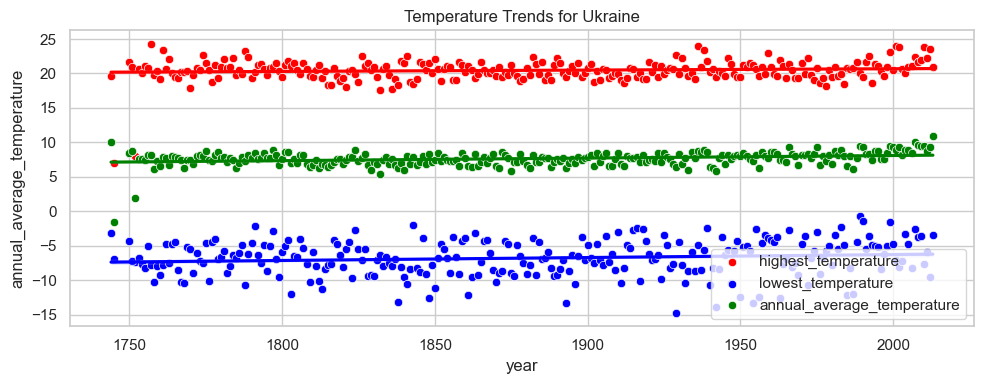

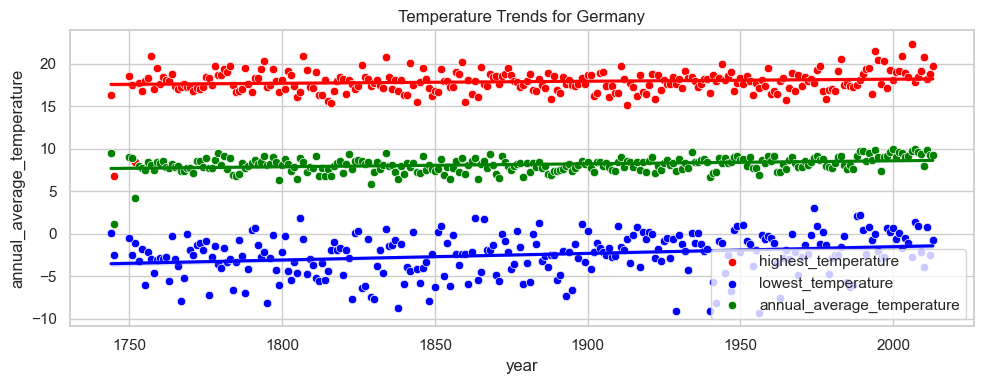

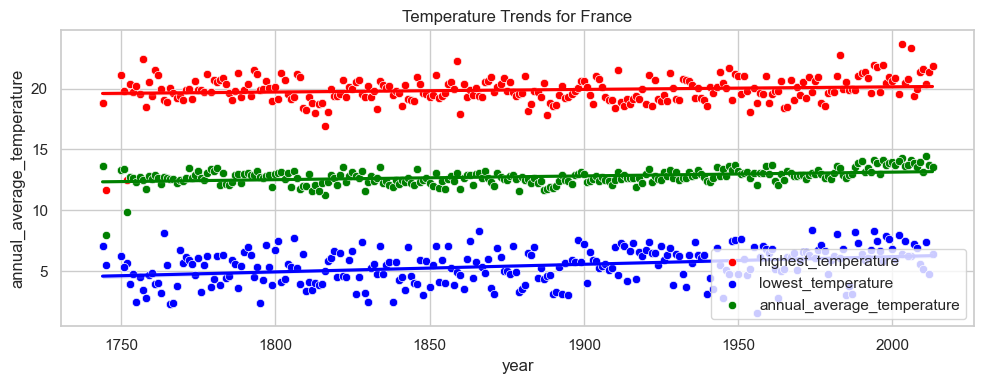

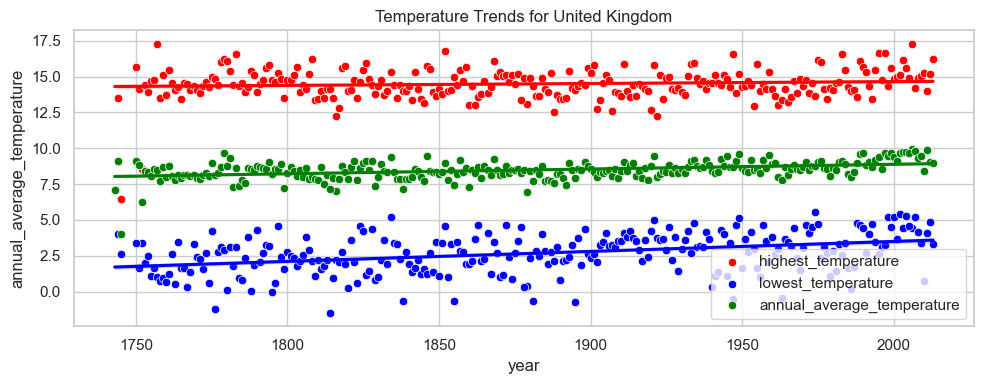

In [60]:
country_plotter(united_data, temperature_categories, country_list)

In [61]:
def country_plotter(df, temperature_categories, country_list, figure_size=(10, 4)):
    # Create scatter plots and trendlines for each category on the same plot, one plot per country
    sns.set(style="whitegrid")
    categories_to_plot = list(temperature_categories.keys())
    
    num_countries = len(country_list)
    num_cols = 2  # Number of columns for subplots
    num_rows = (num_countries + 1) // 2  # Calculate the number of rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figure_size)
    fig.suptitle('Temperature Trends')

    for i, country in enumerate(country_list):
        row = i // 2
        col = i % 2
        ax = axes[row, col]

        for category, color in temperature_categories.items():
            country_data = df[df['country'] == country]
            sns.scatterplot(x='year', y=category, data=country_data, label=f'{category}', color=color, ax=ax)
            sns.regplot(x='year', y=category, data=country_data, color=color, scatter=False, ax=ax)

        ax.set_title(f'{country}')
        ax.legend(loc='best')
        ax.set_xlabel('Year')
        ax.set_ylabel('Temperature')

    # Hide any unused subplots
    for i in range(len(country_list), num_rows * num_cols):
        row = i // 2
        col = i % 2
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


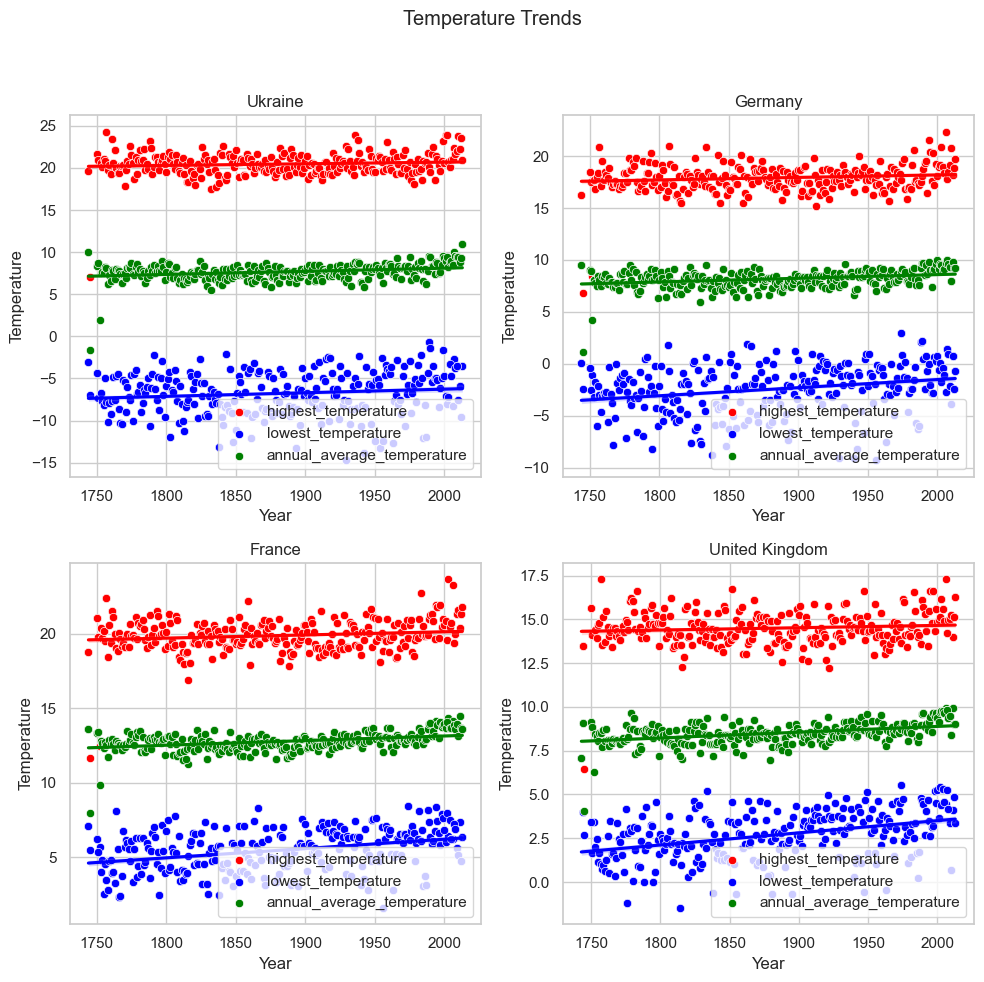

In [62]:
country_plotter(united_data, temperature_categories, country_list, figure_size=(10, 10))


In [63]:
#united_data = remove_outliers(united_data, country_list, list(temperature_categories.keys()))
united_data = united_data.drop(columns=['index'], errors='ignore') \
                       .query('1750 <= year <= 2013') \
                       .reset_index(drop=True)


In [64]:
united_data

,country,year,highest_temperature,lowest_temperature,annual_average_temperature
0,Ukraine,1750,21.606,-4.372,8.390818
1,Ukraine,1751,20.916,-7.272,8.709625
2,Ukraine,1753,20.610,-6.765,7.525083
3,Ukraine,1754,20.068,-7.715,7.635250
4,Ukraine,1755,21.025,-8.194,7.478250
...,...,...,...,...,...
3123,United Kingdom,2008,14.935,4.175,9.348250
3124,United Kingdom,2009,15.040,3.379,9.453333
3125,United Kingdom,2010,15.245,0.711,8.394333
3126,United Kingdom,2012,15.152,4.845,9.037417


In [100]:
model = LinearRegression()

def split_data(df, country_list, temperature_category, random_state=42):
    data_dict = {}
    for country in country_list:
        country_subset = df[df['country'] == country]
        X = country_subset[['year']]
        y = country_subset[temperature_category]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
        data_dict[country] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
    return data_dict

def split_lin(df, country_list, temperature_category, split_percentage=0.75):
    data_dict = {}
    for country in country_list:
        country_subset = df[df['country'] == country]
        X = country_subset[['year']]
        y = country_subset[temperature_category]
        
        split_index = int(len(X) * split_percentage)
        
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]
        
        data_dict[country] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
        print(f'Split index for {country}: {split_index}')
        print(f'Last year in X_train for {country}: {X_train.iloc[-1]}')
        print(f'First year in X_test for {country}: {X_test.iloc[0]}')
    
    return data_dict


def train_linear_regression(data_dict, temperature_categories):
    regressors = {}

    for country, data in data_dict.items():
        for category in temperature_categories:
            X_train, y_train = data['X_train'], data['y_train']
            try:
                regressor = LinearRegression()
                regressor.fit(X_train, y_train)
                if country not in regressors:
                    regressors[country] = {}
                regressors[country][category] = regressor
            except Exception:
                pass

    return regressors


def test_linear_regression(regressors, temperature_categories, data_dict):
    for country, data in data_dict.items():
        print(f'Temperature Predictions for {country}:')
        for category in temperature_categories:
            if country in regressors and category in regressors[country]:
                regressor = regressors[country][category]
                X_test, y_test = data['X_test'], data['y_test']
                y_pred = regressor.predict(X_test)
                #print(f'{category}:')
                #print(y_pred)


In [103]:
#xy_splits=split_data(united_data,country_list, categories_to_plot,random_state=42)
xy_splits=split_lin(united_data, country_list, categories_to_plot, split_percentage=0.9)
xy_splits

Split index for Ukraine: 703
Last year in X_train for Ukraine: year    1932
Name: 702, dtype: int64
First year in X_test for Ukraine: year    1933
Name: 703, dtype: int64
Split index for Germany: 703
Last year in X_train for Germany: year    1934
Name: 1484, dtype: int64
First year in X_test for Germany: year    1935
Name: 1485, dtype: int64
Split index for France: 702
Last year in X_train for France: year    1930
Name: 2265, dtype: int64
First year in X_test for France: year    1931
Name: 2266, dtype: int64
Split index for United Kingdom: 704
Last year in X_train for United Kingdom: year    1932
Name: 3048, dtype: int64
First year in X_test for United Kingdom: year    1933
Name: 3049, dtype: int64


{'Ukraine': {'X_train':      year
  0    1750
  1    1751
  2    1753
  3    1754
  4    1755
  ..    ...
  698  1928
  699  1929
  700  1930
  701  1931
  702  1932
  
  [703 rows x 1 columns],
  'X_test':      year
  703  1933
  704  1934
  705  1935
  706  1936
  707  1937
  ..    ...
  777  2008
  778  2009
  779  2010
  780  2011
  781  2012
  
  [79 rows x 1 columns],
  'y_train':      highest_temperature  lowest_temperature  annual_average_temperature
  0                 21.606              -4.372                    8.390818
  1                 20.916              -7.272                    8.709625
  2                 20.610              -6.765                    7.525083
  3                 20.068              -7.715                    7.635250
  4                 21.025              -8.194                    7.478250
  ..                   ...                 ...                         ...
  698               20.623              -7.596                    6.796917
  699       

In [104]:
list(temperature_categories.keys())

['highest_temperature', 'lowest_temperature', 'annual_average_temperature']

In [136]:
united_data

,country,year,highest_temperature,lowest_temperature,annual_average_temperature
0,Ukraine,1750,21.606,-4.372,8.390818
1,Ukraine,1751,20.916,-7.272,8.709625
2,Ukraine,1753,20.610,-6.765,7.525083
3,Ukraine,1754,20.068,-7.715,7.635250
4,Ukraine,1755,21.025,-8.194,7.478250
...,...,...,...,...,...
3123,United Kingdom,2008,14.935,4.175,9.348250
3124,United Kingdom,2009,15.040,3.379,9.453333
3125,United Kingdom,2010,15.245,0.711,8.394333
3126,United Kingdom,2012,15.152,4.845,9.037417


In [105]:
# Train the linear regression models
regressors = train_linear_regression(xy_splits, list(temperature_categories.keys()))


In [139]:
#load additiona data for the last decade
last_decade=pd.read_csv(r"..\data\anno_temps_lastdecade.csv")

In [140]:
last_decade

,country,year,highest_temperature,lowest_temperature,annual_average_temperature
0,Germany,2014,17.7,0.3,10.64
1,Germany,2015,17.1,3.3,10.32
2,Germany,2016,18.4,1.9,9.86
3,Germany,2017,17.8,3.6,9.91
4,Germany,2018,17.9,1.0,10.74
5,Germany,2019,19.3,1.5,10.50
6,Germany,2020,19.3,2.8,10.79
7,Germany,2021,18.2,4.2,9.49
8,France,2014,NaN,NaN,11.08
9,France,2015,NaN,NaN,12.47


In [144]:
combined_data = pd.concat([united_data, last_decade])
combined_data.reset_index()
combined_data


,country,year,highest_temperature,lowest_temperature,annual_average_temperature
0,Ukraine,1750,21.606,-4.372,8.390818
1,Ukraine,1751,20.916,-7.272,8.709625
2,Ukraine,1753,20.610,-6.765,7.525083
3,Ukraine,1754,20.068,-7.715,7.635250
4,Ukraine,1755,21.025,-8.194,7.478250
...,...,...,...,...,...
27,United Kingdom,2017,NaN,NaN,9.620000
28,United Kingdom,2018,NaN,NaN,9.500000
29,United Kingdom,2019,NaN,NaN,9.550000
30,United Kingdom,2020,NaN,NaN,9.680000


In [145]:
xy_splits2=split_lin(combined_data, country_list, categories_to_plot, split_percentage=0.9)

Split index for Ukraine: 711
Last year in X_train for Ukraine: year    1940
Name: 710, dtype: int64
First year in X_test for Ukraine: year    1941
Name: 711, dtype: int64
Split index for Germany: 711
Last year in X_train for Germany: year    1942
Name: 1492, dtype: int64
First year in X_test for Germany: year    1943
Name: 1493, dtype: int64
Split index for France: 710
Last year in X_train for France: year    1938
Name: 2273, dtype: int64
First year in X_test for France: year    1939
Name: 2274, dtype: int64
Split index for United Kingdom: 711
Last year in X_train for United Kingdom: year    1939
Name: 3055, dtype: int64
First year in X_test for United Kingdom: year    1940
Name: 3056, dtype: int64


In [150]:
# Train the linear regression models
regressors = train_linear_regression(xy_splits2, list(temperature_categories.keys()))

In [151]:
def plot_combined_linear_regression(xy_splits, country, temperature_categories, regressors, df):
    # Get the data for the specified country
    data = xy_splits[country]
    X_train, X_test = data['X_train'], data['X_test']
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'{country} Linear Regression Predictions', fontsize=16)

    for category in temperature_categories:
        if category in regressors[country]:
            regressor = regressors[country][category]
            y_train = data['y_train'][category]
            y_pred = regressor.predict(X_test)

            # Scatter plot for the training data
            plt.scatter(X_train, y_train, label=f'{category} Train Data')

            # Scatter plot for the test data
            plt.scatter(X_test, y_test, label=f'{category} Test Data')

            # Plot the linear regression prediction for the current category
            plt.plot(X_test, y_pred, label=f'{category} Prediction')

    plt.title(f'{country} Linear Regression Predictions')
    plt.xlabel('Year')
    plt.legend()
    plt.tight_layout()
    plt.show()

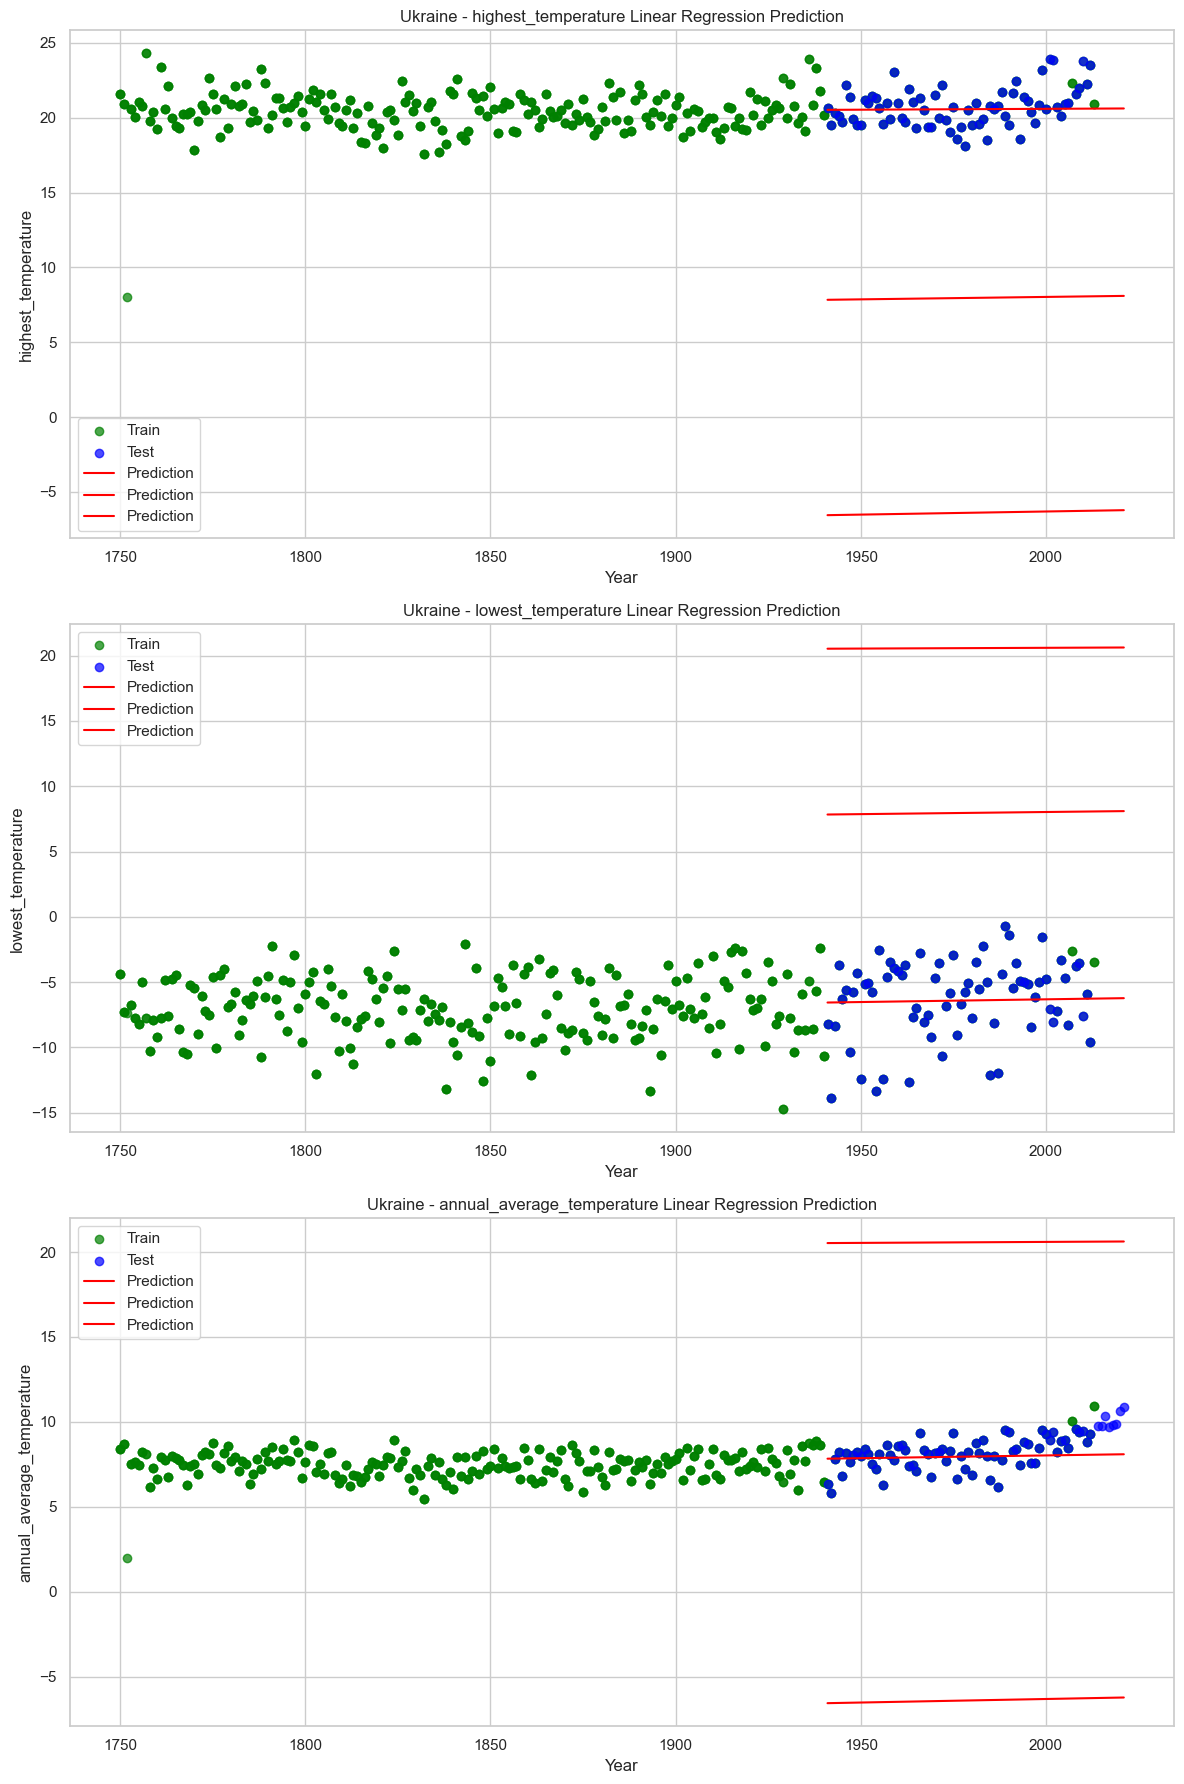

In [152]:
plot_linear_regression_for_categories(xy_splits2, "Ukraine", temperature_categories, regressors)

In [153]:
def plot_combined_linear_regression(xy_splits2, country_list, temperature_categories, regressors, df):
    num_countries = len(country_list)
    num_categories = len(temperature_categories)
    
    fig, axes = plt.subplots(num_countries, num_categories, figsize=(16, 10))
    fig.suptitle('Linear Regression Predictions', fontsize=16)

    for i, country in enumerate(country_list):
        for j, category in enumerate(temperature_categories):
            ax = axes[i, j]
            ax.set_title(f'{country} - {category}')

            # Get the data for the specified country and category
            data = xy_splits[country]
            X_train, X_test = data['X_train'], data['X_test']
            y_train = data['y_train'][category]
            regressor = regressors[country][category]
            y_pred = regressor.predict(X_test)

            # Scatter plot for the training data
            ax.scatter(X_train, y_train, label='Train Data')

            # Scatter plot for the test data
            ax.scatter(X_test, data['y_test'][category], label='Test Data')

            # Plot the linear regression prediction for the current category
            ax.plot(X_test, y_pred, label='Prediction')

    for ax in axes.flat:
        ax.set(xlabel='Year', ylabel='Temperature')
        ax.legend()

    # Adjust the layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

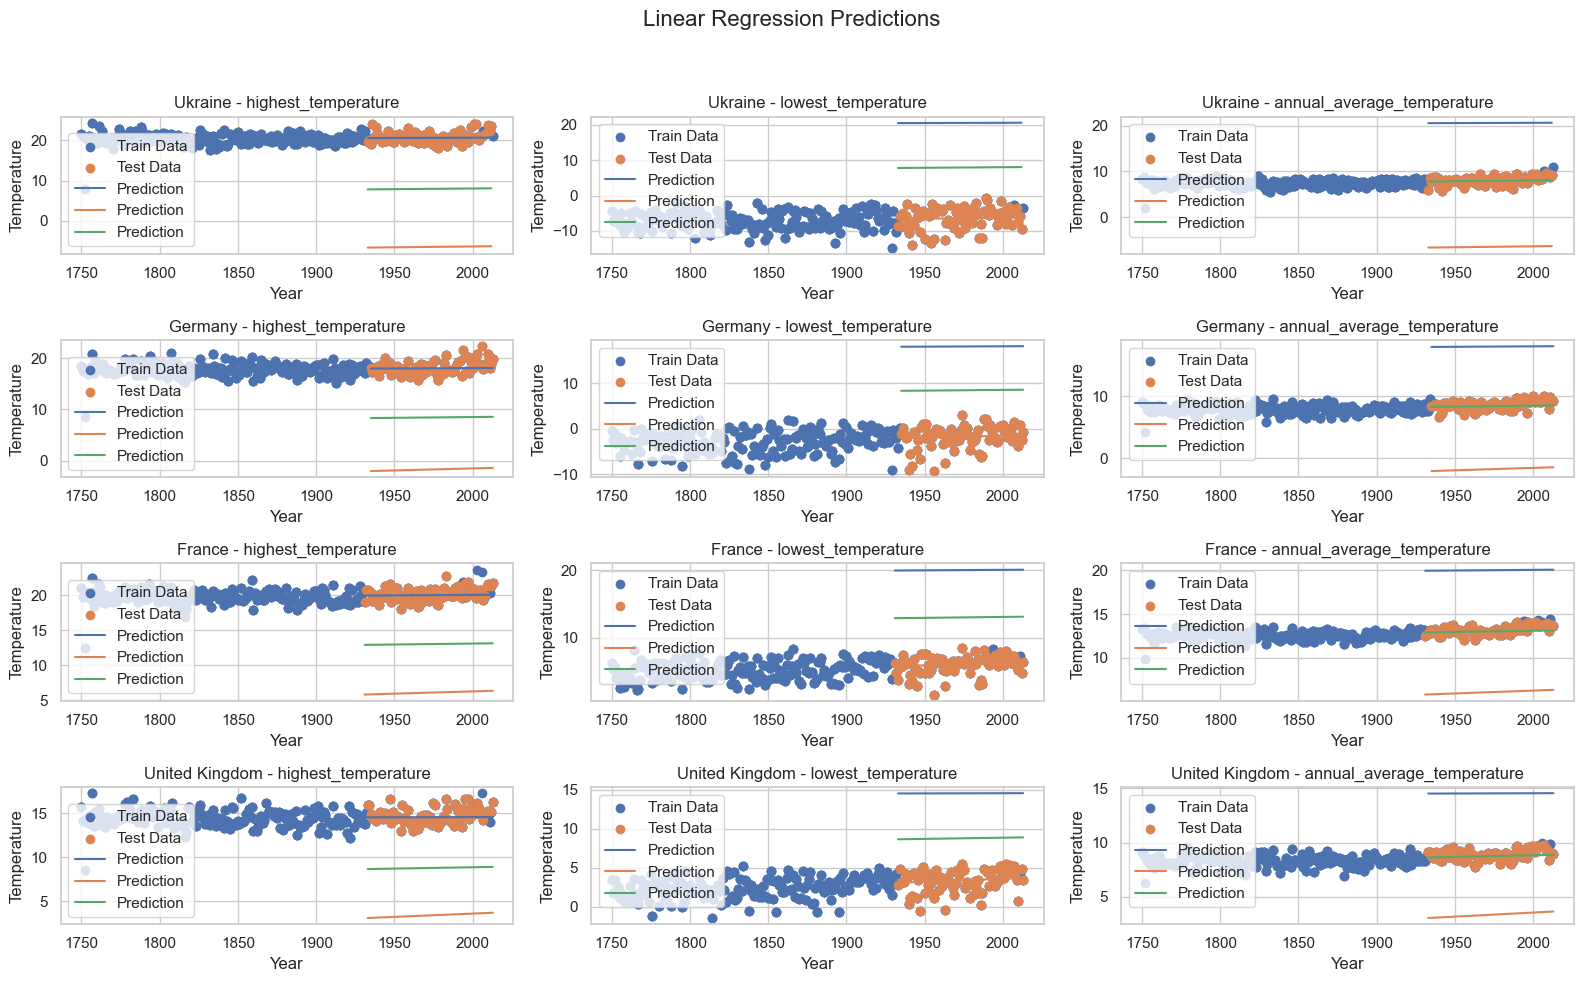

In [154]:
plot_combined_linear_regression(xy_splits, country_list, temperature_categories, regressors, united_data)

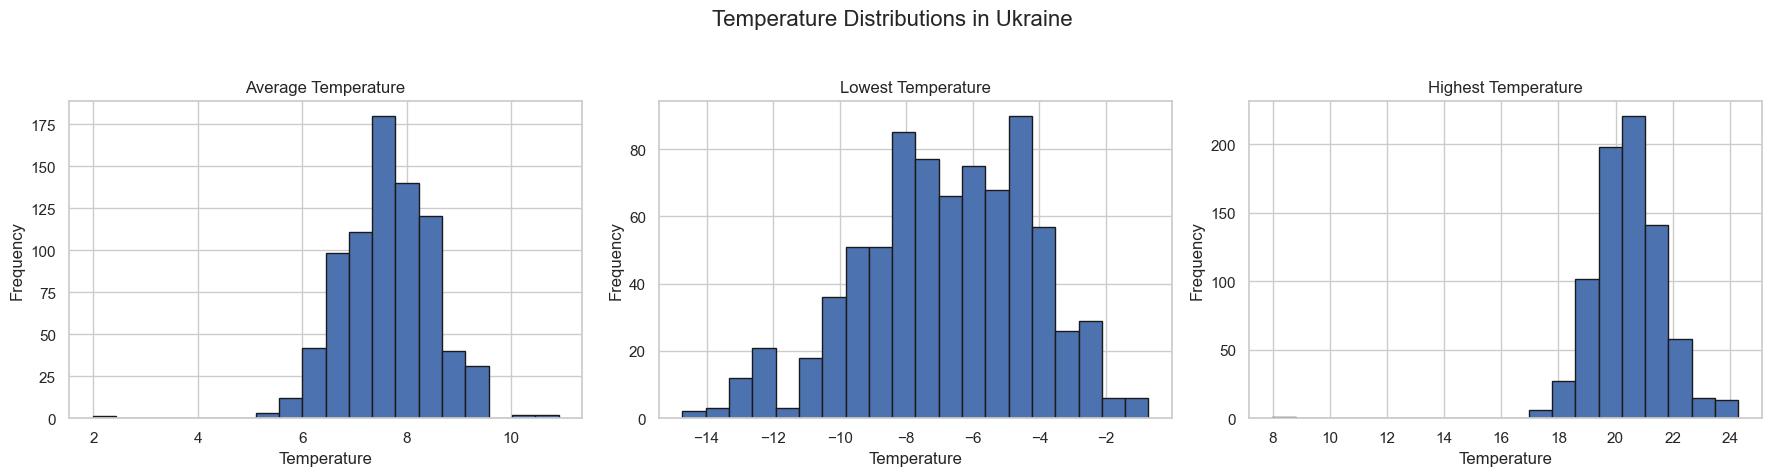

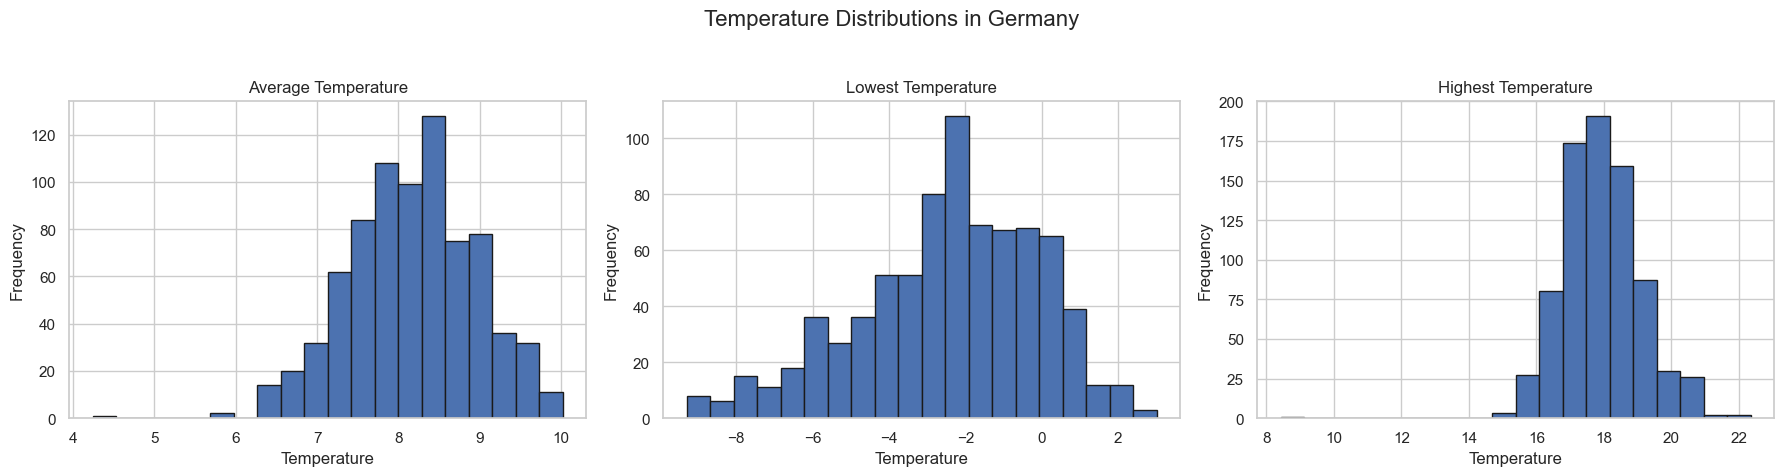

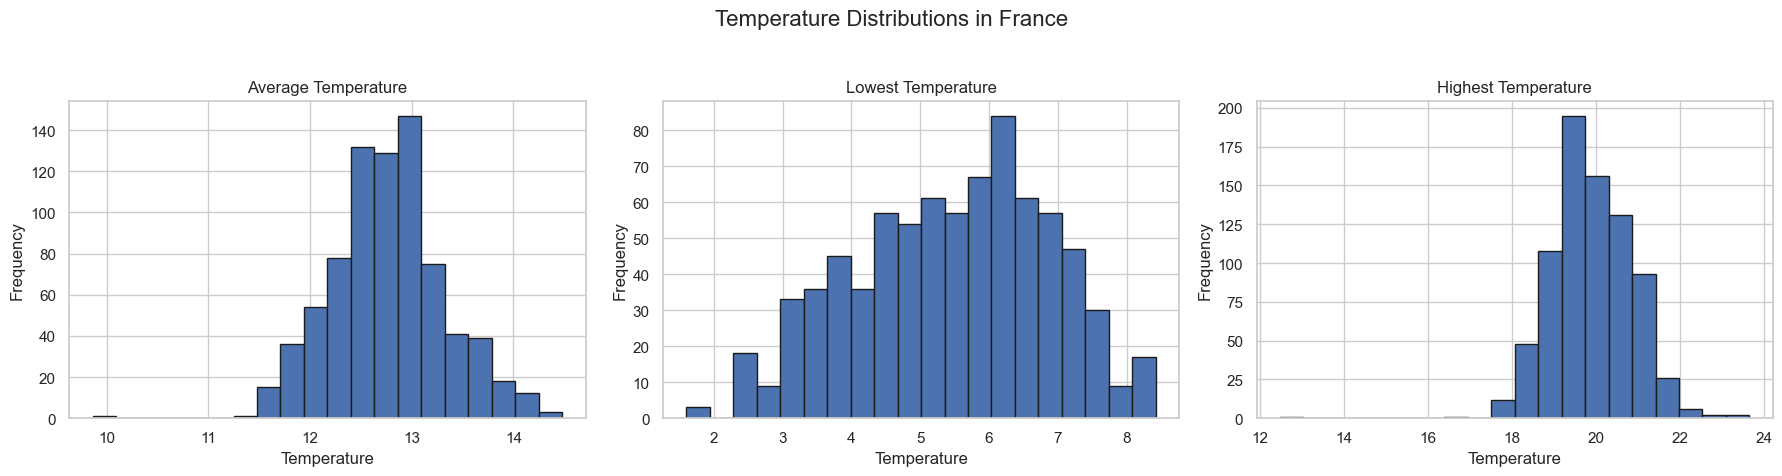

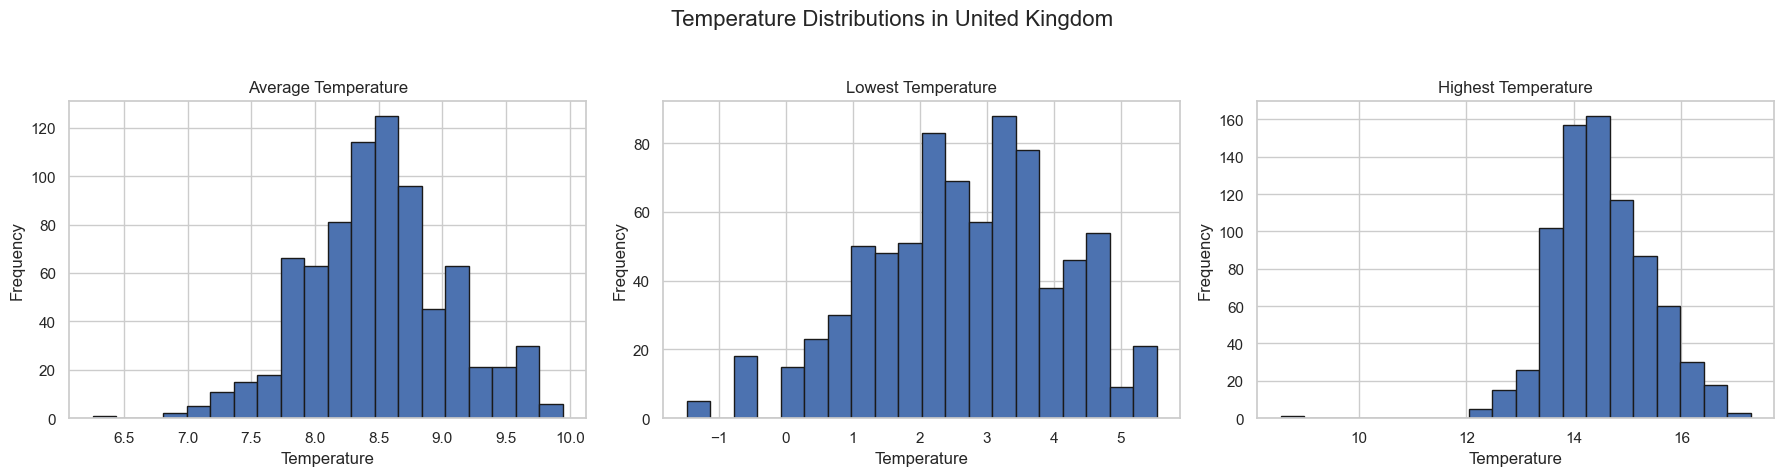

In [73]:
# Get the unique countries
unique_countries = united_data['country'].unique()

# Set the number of bins for the histograms
num_bins = 20

# Create a separate set of histograms for each country
for country in unique_countries:
    country_data = united_data[united_data['country'] == country]

    # Extract temperature data
    avg_temperatures = country_data['annual_average_temperature'].values
    lowest_temperatures = country_data['lowest_temperature'].values
    highest_temperatures = country_data['highest_temperature'].values

    # Create subplots for each temperature metric
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.suptitle(f'Temperature Distributions in {country}', fontsize=16)

    axes[0].hist(avg_temperatures, bins=num_bins, edgecolor='k')
    axes[0].set_title('Average Temperature')
    axes[0].set_xlabel('Temperature')
    axes[0].set_ylabel('Frequency')

    axes[1].hist(lowest_temperatures, bins=num_bins, edgecolor='k')
    axes[1].set_title('Lowest Temperature')
    axes[1].set_xlabel('Temperature')
    axes[1].set_ylabel('Frequency')

    axes[2].hist(highest_temperatures, bins=num_bins, edgecolor='k')
    axes[2].set_title('Highest Temperature')
    axes[2].set_xlabel('Temperature')
    axes[2].set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

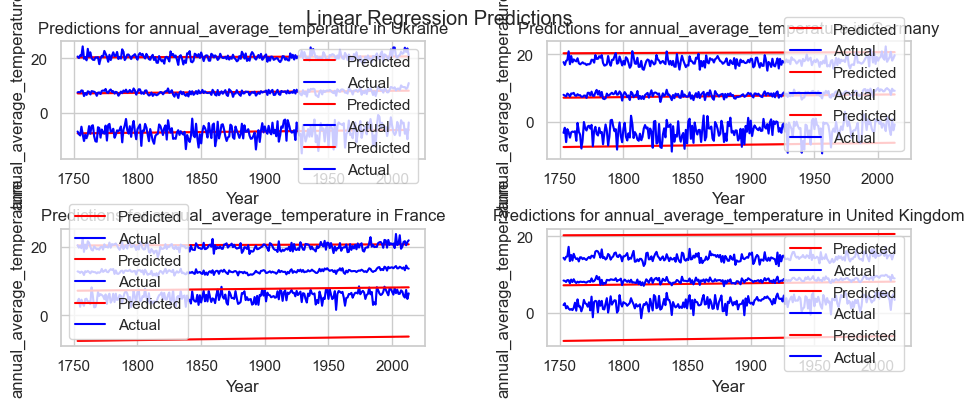

In [87]:
# Create linear regression plots
create_linear_regression_plots(regressors, united_data, list(temperature_categories.keys()), country_list,figsize=(10, 4))

So we cannot use regressor trained for one country ("Ukraine") for other countries, even for same categories.
This makes sense in fact due to different geographical and thus - climate conditions, even though general behaviour seem ok, the free parameter of the offset is to be imroved. Normalization looks best option here - by subtracting the mean avg temp for the country

Prediction for next 50 years

In [159]:
# List of countries and temperature categories
country_list = ['Ukraine', 'France', 'Germany']
temperature_categories = ['highest_temperature', 'lowest_temperature', 'annual_average_temperature'] 

# Create a list of future years for prediction
current_year = 2023  # Replace with the current year
future_years = [current_year + i for i in range(1, 51)]  # Next 50 years
# Create a list of years for the next 50 years
next_50_years = list(range(2024, 2074))

# Create a dictionary to store the predictions
predictions = {}
categories_to_plot=["annual_average_temperature"] #limit, because of NaN is other categories in the last decade
# Iterate through each country
for country in xy_splits.keys():
    predictions[country] = {}
    
    # Iterate through each temperature category
    for category in categories_to_plot:
        # Get the linear regressor for the current combination
        regressor = regressors[country][category]
        
        # Use the regressor to make predictions for the next 50 years
        X_next_years = np.array(next_50_years).reshape(-1, 1)
        y_pred = regressor.predict(X_next_years)
        
        # Store the predictions for this country and category
        predictions[country][category] = {'years': next_50_years, 'predictions': y_pred}



C:\Users\IGloc\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\IGloc\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\IGloc\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\IGloc\anaconda3\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [167]:
# Define a function to plot predictions for a specific country and category
def plot_predictions_with_scatter(country, category):
    plt.figure(figsize=(12, 6))
    years = predictions[country][category]['years']
    predicted_values = predictions[country][category]['predictions']
    
    # Scatter plot for the actual data before the "year" in X_test
    country_data_filtered = united_data[(united_data['country'] == country) & (united_data['year'] <= min(years))]
    plt.scatter(country_data_filtered['year'], country_data_filtered[category], label=f'{country} Data', color='blue')
    
    # Plot the predictions
    plt.plot(years, predicted_values, label=f'{country} - {category} Prediction', color="red")
    
    plt.title(f'{country} - {category} Predictions vs. Actual Data')
    plt.xlabel('Year')
    plt.ylabel(category)
    plt.legend()
    plt.grid()

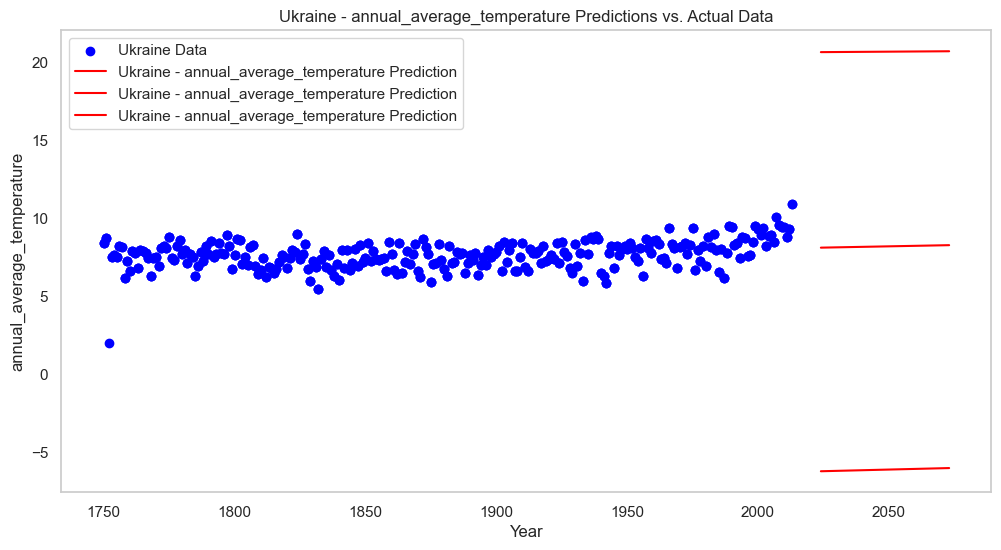

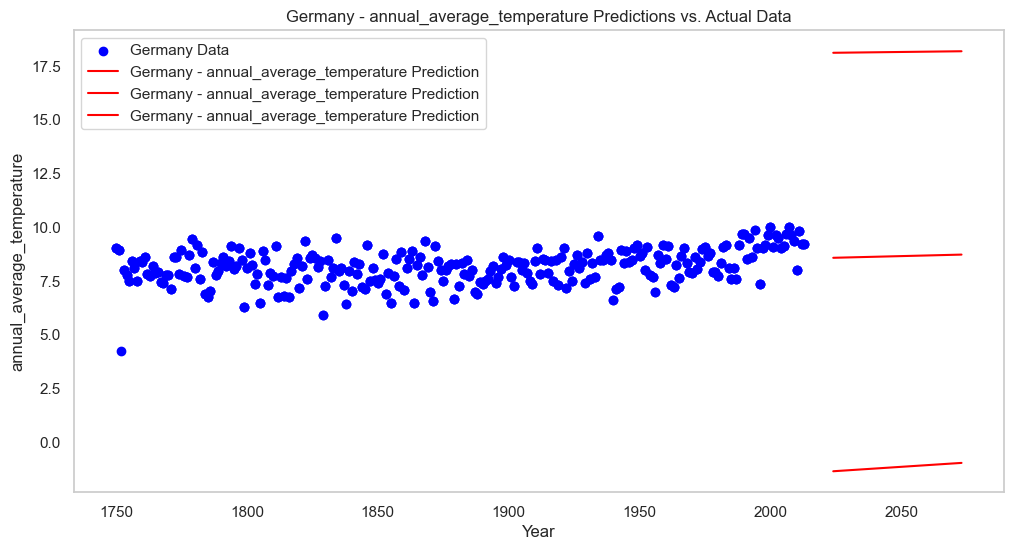

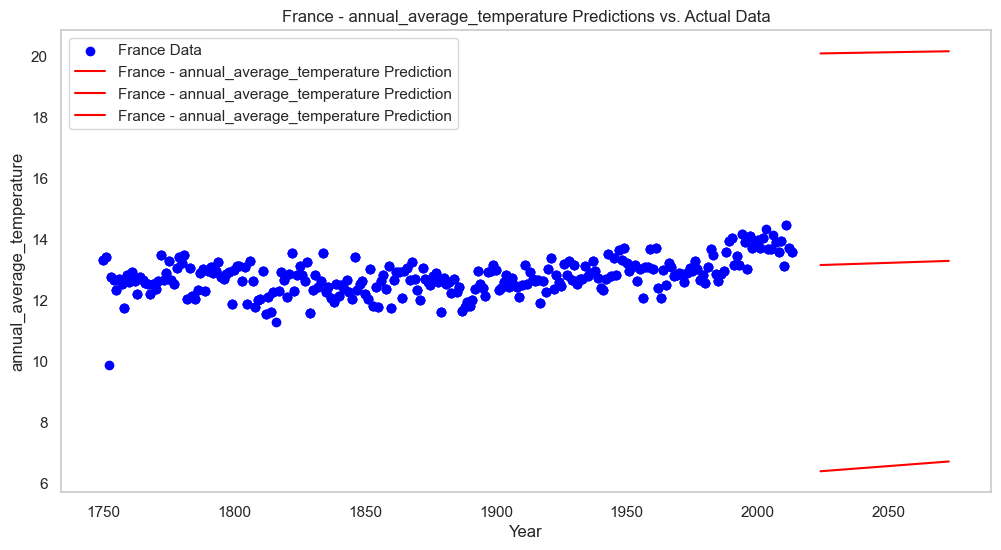

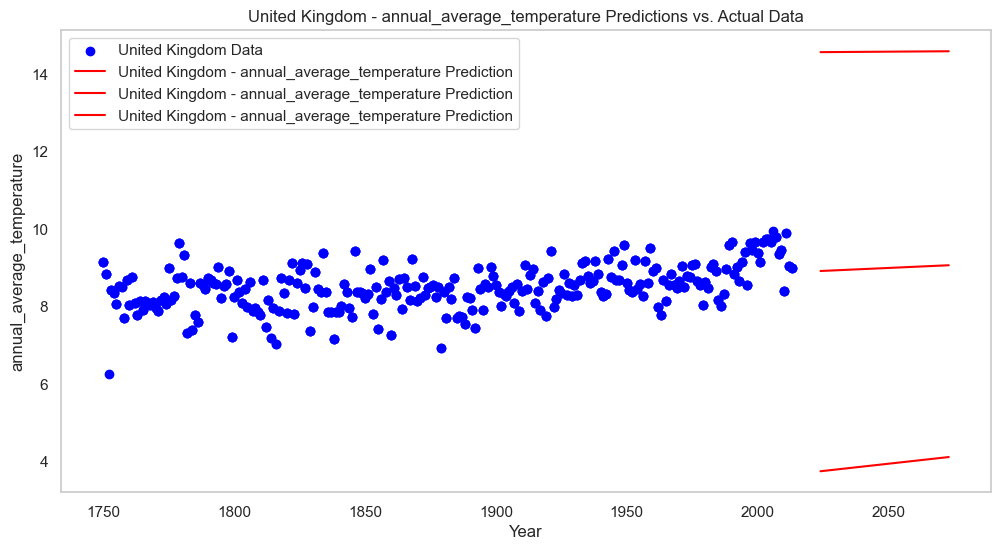

In [168]:
# Plot predictions and scatter plots for each country and category
for country in predictions.keys():
    for category in categories_to_plot:
        plot_predictions_with_scatter(country, category)

plt.show()

Polynomial of 2nd order


Elbow for France_annual_average_temperature: 0.2228
Elbow for Germany_annual_average_temperature: 0.4959
Elbow for Ukraine_annual_average_temperature: 0.8176


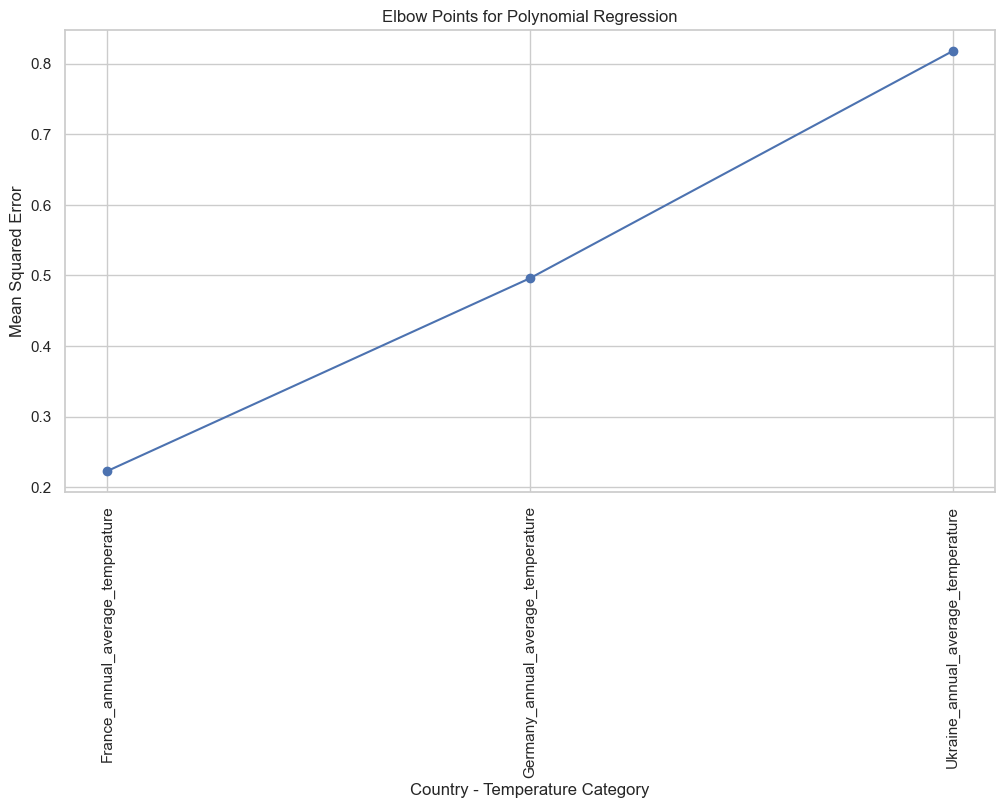

In [172]:
# Define the order of the polynomial
degree = 2

# Create a dictionary to store the elbow points for each country
elbows = {}
categories=["annual_average_temperature"]

# Iterate through each country
for country in country_list:
    country_data = combined_data[combined_data['country'] == country]
    # Iterate through each temperature category
    for category in categories:
        X = country_data['year'].values.reshape(-1, 1)
        y = country_data[category].values

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X_train)

        # Fit the polynomial regression model
        model = LinearRegression()
        model.fit(X_poly, y_train)

        # Make predictions
        X_poly_test = poly.transform(X_test)
        y_pred = model.predict(X_poly_test)

        # Calculate the Mean Squared Error
        mse = mean_squared_error(y_test, y_pred)

        # Store the MSE for this category
        elbows[f'{country}_{category}'] = mse

# Find the elbow points by sorting the MSE values
elbows_sorted = dict(sorted(elbows.items(), key=lambda item: item[1]))

# Print the elbow points
for key, value in elbows_sorted.items():
    print(f'Elbow for {key}: {value:.4f}')

# Plot the elbow points
plt.figure(figsize=(12, 6))
plt.plot(elbows_sorted.keys(), elbows_sorted.values(), marker='o')
plt.title('Elbow Points for Polynomial Regression')
plt.xlabel('Country - Temperature Category')
plt.xticks(rotation=90)
plt.ylabel('Mean Squared Error')
plt.show()

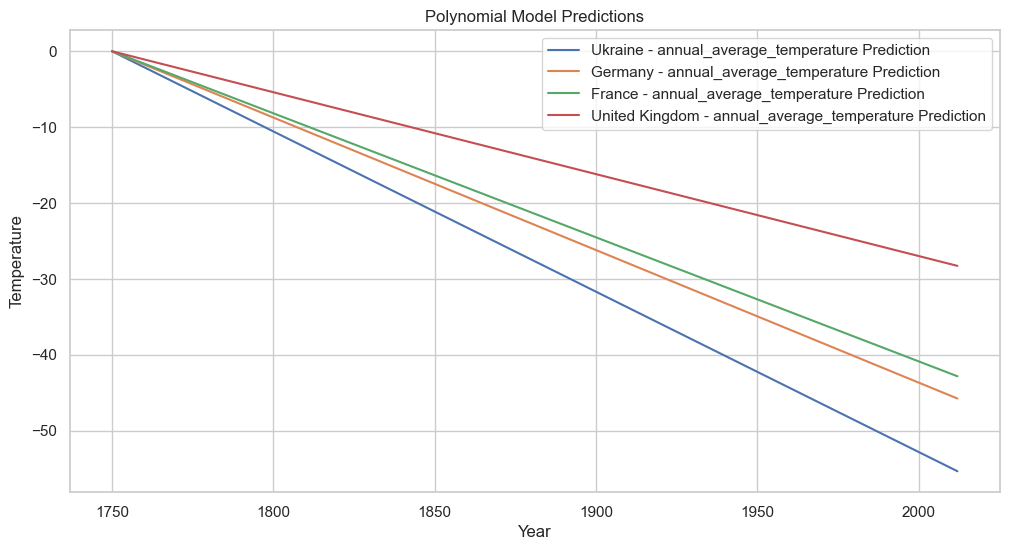

In [185]:
# Define the number of years for prediction
years_to_predict = np.arange(1750, 2013)

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Create an empty dictionary to store the polynomial models and coefficients
polynomial_models = {}
polynomial_coefficients = {}

# Iterate through countries
for country in united_data['country'].unique():
    polynomial_models[country] = {}
    polynomial_coefficients[country] = {}
    
    # Iterate through temperature categories
    for category in categories_to_plot:
        # Filter data for the current country and category
        country_data = united_data[(united_data['country'] == country) & (united_data['annual_average_temperature'])]
        
        # Extract the years and temperatures
        years = country_data['year'].values.reshape(-1, 1)
        temperatures = country_data['annual_average_temperature'].values

        # Create a polynomial regression model
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

        # Fit the model to the data
        model.fit(years, temperatures)

        # Store the model in the dictionary
        polynomial_models[country][category] = model

        # Extract the coefficients from the linear regression step of the pipeline
        coefficients = model.named_steps['linearregression'].coef_
        polynomial_coefficients[country][category] = coefficients

        

for country in united_data['country'].unique():
    for category in categories_to_plot:
        # Retrieve the data for the current country and category
        country_data = united_data[(united_data['country'] == country) & (united_data['annual_average_temperature'])]

        # Get the polynomial coefficients for the current country and category
        coefficients = polynomial_models[country][category].named_steps['linearregression'].coef_

        # Predict the temperatures for the next 50 years using the polynomial model
        predictions = np.polyval(coefficients, years_to_predict - 1750)

        # Plot the predictions
        ax.plot(years_to_predict, predictions, label=f'{country} - {category} Prediction')

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Temperature')
ax.set_title('Polynomial Model Predictions')

# Add a legend
ax.legend()

# Show the plot
plt.show()


Augmented Dickey-Fuller (ADF) statistics is widely used statistical test to check whether the time series is stationary or not.
It uses an autoregressive model and optimizes an information criterion across multiple different lag values.
Null Hypothesis: Series is not stationary.
Alternate Hypothesis: Series is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','No. of Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
adf_test(data)

p-value < 0.05 (significance) - indicating the data is stationary, therefore we reject the null hypothesis.

KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test is a statistical test to check for stationarity of a series around a deterministic trend. KPSS test figures out if a time series is stationary around a mean or linear trend or is non-stationary due to a unit root.

Null Hypothesis: The series is trend stationary.
Alternate Hypothesis: The series is not stationary.

In [ ]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression = 'c', nlags = 'legacy')
    kpss_output = pd.Series(kpsstest[0:3], index = ['Test Statistic','p-value','No. of Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
kpss_test(data)

The p-value is greater than the level of significance (0.05) and hence it is weak evidence against the null hypothesis and therefore we fail to reject the null hypothesis. This indicates that our time series is stationary.

Both ADF and KPSS tests are in agreement that the time series data is stationary.

Assigning Frequency to the Time Series Data:
We resample the data with 'MS' (Month Start) as the frequency. Although the data already consisted of only monthly samples, resampling it this way assigns a frequency to it. Frequency ambiguity could lead to the SARIMAX model auto-assigning the frequency which should be avoided.

In [ ]:
y = data['AverageTemperature'].resample('MS').mean()
y.head()

In [ ]:
#Train and Test Splits:¶
train = y[:'2009']
test = y['2010':]